In [1]:
import sys
sys.path.append('../src')
from util import load_balls, preprocess_data
from dataset import nballDataset
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
from transformers import BertModel, AdamW
from tqdm import tqdm

In [2]:
bert_models = {"BERT-Base": ["bert-base-uncased", 768], #768, 12L, 12A
               "BERT-Large": ["bert-large-uncased", 1024], #1024, 24L, 16A
               "BERT-Medium": ["google/bert_uncased_L-8_H-512_A-8", 512], #512, 8L, 8A
               "BERT-Small": ["google/bert_uncased_L-4_H-256_A-4", 256], #256, 4L, 4A
               "BERT-Mini": ["google/bert_uncased_L-4_H-128_A-2", 128],#128, 4L, 2A
               "BERT-Tiny": ["google/bert_uncased_L-2_H-128_A-2", 128]}#128, 2L, 2A

In [3]:
# Load data
semcor_training_xml_path = '../data/WSD_Evaluation_Framework/Training_Corpora/Semcor/semcor.data.xml'
semcor_training_gk_path = '../data/WSD_Evaluation_Framework/Training_Corpora/Semcor/semcor.gold.key.txt'
nball_mammal_file = '../data/sample_mammal/nball.txt'
nball = load_balls(nball_mammal_file)
training_set = preprocess_data(semcor_training_xml_path, semcor_training_gk_path)
display(training_set.head())

loading balls....
388 balls are loaded



,lemma,word,sentence_text,formatted_sense_id
0,long,long,How long has it been since you reviewed the ob...,long.a.01
1,be,been,How long has it been since you reviewed the ob...,be.v.01
2,review,reviewed,How long has it been since you reviewed the ob...,review.v.01
3,objective,objectives,How long has it been since you reviewed the ob...,aim.n.02
4,benefit,benefit,How long has it been since you reviewed the ob...,benefit.n.01


In [4]:
max_length = 512
batch_size = 32
model_url = bert_models["BERT-Small"][0]

In [5]:
dataset = nballDataset(training_set, nball, model_url, max_length)

Tokenizing sentences...
Tokenizing finished.
Calculating word indices...
Tokenizing finished.


In [6]:
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [7]:
# Model
class nballBertModelNorm(nn.Module):
    def __init__(self, model_url, output_dim):
        super(nballBertModelNorm, self).__init__()
        self.model_url = model_url
        self.bert = BertModel.from_pretrained(self.model_url)
        self.projection = nn.Linear(self.bert.config.hidden_size, output_dim)
        # Direct regression for norm
        self.regressor = nn.Linear(output_dim, 1)
        
    def forward(self, input_ids, attention_mask, word_index):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        word_embeddings = hidden_states[range(len(word_index)), word_index]
        projected_output = self.projection(word_embeddings)
        # norm = torch.norm(projected_output, p=2, dim=1) 
        norm = self.regressor(projected_output)
        return norm


class nballBertModelDirection(nn.Module):
    def __init__(self, model_url, output_dim):
        super(nballBertModelDirection, self).__init__()
        self.model_url = model_url
        self.bert = BertModel.from_pretrained(self.model_url)
        self.projection = nn.Linear(self.bert.config.hidden_size, output_dim)
        
    def forward(self, input_ids, attention_mask, word_index):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        word_embeddings = hidden_states[range(len(word_index)), word_index]
        projected_output = self.projection(word_embeddings)
        return projected_output

In [8]:
# Config for training norm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

def log_cosh_loss(norm_u, norm_v):
    return torch.log(torch.cosh(norm_u - norm_v)).mean()

output_dim = 160
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nballBertModelNorm(model_url, output_dim).to(device)
loss_fn = log_cosh_loss
optimizer = optim.Adam([
    {'params': model.parameters()}
], lr=2e-4)
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

In [12]:
num_epochs = 100
last_loss = 0

for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True, position=0)
    for batch in progress_bar:
        # Unpack batch and send to device
        batch_input_ids, batch_attention_masks, batch_word_indices, batch_nball, batch_norm\
        , batch_sense_indices = [b.to(device) for b in batch]
        b_norm = batch_norm.squeeze()

        optimizer.zero_grad()
        
        # Forward pass
        output_norm = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, \
                            word_index=batch_word_indices).squeeze()

        loss = loss_fn(output_norm, batch_norm * 1e-5)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    # Logging average metrics per epoch
    avg_loss = total_loss / len(dataloader)
    improvement = (last_loss - total_loss) / len(dataloader) if last_loss != 0 else 0
    print(f'Epoch {epoch + 1}, Avg Loss: {avg_loss}, Improvement: {improvement}')
    last_loss = total_loss

    scheduler.step()

Epoch 1/100: 100%|███████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.84it/s, loss=5.9]


Epoch 1, Avg Loss: 5.846156120300293, Improvement: 0


Epoch 2/100: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.08it/s, loss=2.26]


Epoch 2, Avg Loss: 4.522917248985984, Improvement: 1.3232388713143088


Epoch 3/100: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.15it/s, loss=2.88]


Epoch 3, Avg Loss: 3.78069747578014, Improvement: 0.7422197732058439


Epoch 4/100: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.27it/s, loss=2.01]


Epoch 4, Avg Loss: 2.9006378759037363, Improvement: 0.8800595998764038


Epoch 5/100: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.04it/s, loss=2.26]


Epoch 5, Avg Loss: 2.109628135507757, Improvement: 0.7910097403959795


Epoch 6/100: 100%|███████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.15it/s, loss=0.9]


Epoch 6, Avg Loss: 1.5353513360023499, Improvement: 0.5742767995054071


Epoch 7/100: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.60it/s, loss=0.85]


Epoch 7, Avg Loss: 1.0814559676430442, Improvement: 0.45389536835930566


Epoch 8/100: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.93it/s, loss=1.19]


Epoch 8, Avg Loss: 0.783914177255197, Improvement: 0.2975417903878472


Epoch 9/100: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.60it/s, loss=0.841]


Epoch 9, Avg Loss: 0.8396749374541369, Improvement: -0.05576076019893993


Epoch 10/100: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.48it/s, loss=0.593]


Epoch 10, Avg Loss: 0.6135393435304816, Improvement: 0.22613559392365543


Epoch 11/100: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.60it/s, loss=0.51]


Epoch 11, Avg Loss: 0.5545219315046613, Improvement: 0.05901741202582012


Epoch 12/100: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.42it/s, loss=0.463]


Epoch 12, Avg Loss: 0.47430757636373694, Improvement: 0.08021435514092445


Epoch 13/100: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.33it/s, loss=1.06]


Epoch 13, Avg Loss: 0.4394462362609126, Improvement: 0.034861340102824295


Epoch 14/100: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.52it/s, loss=0.393]


Epoch 14, Avg Loss: 0.3773611770434813, Improvement: 0.06208505921743133


Epoch 15/100: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.87it/s, loss=0.313]


Epoch 15, Avg Loss: 0.32993696960197255, Improvement: 0.04742420744150877


Epoch 16/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.35it/s, loss=0.0335]


Epoch 16, Avg Loss: 0.3027864149348302, Improvement: 0.027150554667142304


Epoch 17/100: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.64it/s, loss=0.442]


Epoch 17, Avg Loss: 0.2521745894442905, Improvement: 0.050611825490539726


Epoch 18/100: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.18it/s, loss=0.021]


Epoch 18, Avg Loss: 0.2151418968357823, Improvement: 0.037032692608508194


Epoch 19/100: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.10it/s, loss=0.141]


Epoch 19, Avg Loss: 0.16217678594826299, Improvement: 0.05296511088751934


Epoch 20/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.07it/s, loss=0.0102]


Epoch 20, Avg Loss: 0.12320002490146593, Improvement: 0.03897676104679704


Epoch 21/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.07it/s, loss=0.0584]


Epoch 21, Avg Loss: 0.08655363880097866, Improvement: 0.036646386100487274


Epoch 22/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.94it/s, loss=0.0611]


Epoch 22, Avg Loss: 0.09811161678623069, Improvement: -0.011557977985252033


Epoch 23/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.27it/s, loss=0.0559]


Epoch 23, Avg Loss: 0.05993401072919369, Improvement: 0.03817760605703701


Epoch 24/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.13it/s, loss=0.0618]


Epoch 24, Avg Loss: 0.05307962593029846, Improvement: 0.006854384798895229


Epoch 25/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.90it/s, loss=0.0345]


Epoch 25, Avg Loss: 0.03619324483654716, Improvement: 0.0168863810937513


Epoch 26/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.02it/s, loss=0.0133]


Epoch 26, Avg Loss: 0.050331651233136654, Improvement: -0.014138406396589497


Epoch 27/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.04it/s, loss=0.0632]


Epoch 27, Avg Loss: 0.038218934258276764, Improvement: 0.012112716974859888


Epoch 28/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.58it/s, loss=0.0351]


Epoch 28, Avg Loss: 0.03515535169704394, Improvement: 0.0030635825612328267


Epoch 29/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.50it/s, loss=0.0456]


Epoch 29, Avg Loss: 0.03436837751757015, Improvement: 0.0007869741794737903


Epoch 30/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.49it/s, loss=0.0378]


Epoch 30, Avg Loss: 0.03459800034761429, Improvement: -0.0002296228300441395


Epoch 31/100: 100%|████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.62it/s, loss=0.038]


Epoch 31, Avg Loss: 0.037153054706074974, Improvement: -0.0025550543584606862


Epoch 32/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.40it/s, loss=0.0317]


Epoch 32, Avg Loss: 0.05160939998247407, Improvement: -0.014456345276399092


Epoch 33/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.91it/s, loss=0.0251]


Epoch 33, Avg Loss: 0.03356578658250245, Improvement: 0.018043613399971615


Epoch 34/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.20it/s, loss=0.0217]


Epoch 34, Avg Loss: 0.025271593931723724, Improvement: 0.008294192650778727


Epoch 35/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.59it/s, loss=0.0227]


Epoch 35, Avg Loss: 0.017236900558187204, Improvement: 0.008034693373536522


Epoch 36/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.24it/s, loss=0.0108]


Epoch 36, Avg Loss: 0.0105466702952981, Improvement: 0.006690230262889104


Epoch 37/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.45it/s, loss=0.0115]


Epoch 37, Avg Loss: 0.00957026065919887, Improvement: 0.0009764096360992302


Epoch 38/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.89it/s, loss=0.00472]


Epoch 38, Avg Loss: 0.008427517700263044, Improvement: 0.0011427429589358244


Epoch 39/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.93it/s, loss=0.00557]


Epoch 39, Avg Loss: 0.008134554754095998, Improvement: 0.00029296294616704637


Epoch 40/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.19it/s, loss=0.0092]


Epoch 40, Avg Loss: 0.01032001735769551, Improvement: -0.00218546260359951


Epoch 41/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.07it/s, loss=0.00343]


Epoch 41, Avg Loss: 0.00448079865468158, Improvement: 0.005839218703013929


Epoch 42/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.04it/s, loss=0.00255]


Epoch 42, Avg Loss: 0.00434125994797796, Improvement: 0.0001395387067036195


Epoch 43/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.43it/s, loss=0.00395]


Epoch 43, Avg Loss: 0.005709279116920449, Improvement: -0.0013680191689424894


Epoch 44/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.39it/s, loss=0.0029]


Epoch 44, Avg Loss: 0.005141135093502023, Improvement: 0.0005681440234184265


Epoch 45/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.94it/s, loss=0.00527]


Epoch 45, Avg Loss: 0.004047363610218533, Improvement: 0.00109377148328349


Epoch 46/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.39it/s, loss=0.0146]


Epoch 46, Avg Loss: 0.01108101829463108, Improvement: -0.007033654684412547


Epoch 47/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.17it/s, loss=0.00277]


Epoch 47, Avg Loss: 0.013457082063806329, Improvement: -0.0023760637691752477


Epoch 48/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.86it/s, loss=0.0219]


Epoch 48, Avg Loss: 0.011388894424519756, Improvement: 0.0020681876392865724


Epoch 49/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.11it/s, loss=0.00612]


Epoch 49, Avg Loss: 0.011653495761989192, Improvement: -0.0002646013374694369


Epoch 50/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.98it/s, loss=0.00753]


Epoch 50, Avg Loss: 0.009047871646047994, Improvement: 0.0026056241159411993


Epoch 51/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.49it/s, loss=0.00324]


Epoch 51, Avg Loss: 0.0034466858170079913, Improvement: 0.005601185829040001


Epoch 52/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.38it/s, loss=0.00177]


Epoch 52, Avg Loss: 0.0022433789827945557, Improvement: 0.0012033068342134356


Epoch 53/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.87it/s, loss=0.00157]


Epoch 53, Avg Loss: 0.0015118756405585868, Improvement: 0.0007315033422359688


Epoch 54/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.61it/s, loss=0.000723]


Epoch 54, Avg Loss: 0.0011240551406940954, Improvement: 0.0003878204998644915


Epoch 55/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.20it/s, loss=0.000707]


Epoch 55, Avg Loss: 0.0009107958493669602, Improvement: 0.00021325929132713512


Epoch 56/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.58it/s, loss=0.000681]


Epoch 56, Avg Loss: 0.0007419751888268034, Improvement: 0.00016882066054015675


Epoch 57/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.78it/s, loss=0.000609]


Epoch 57, Avg Loss: 0.0006368549392473968, Improvement: 0.0001051202495794066


Epoch 58/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.97it/s, loss=0.000619]


Epoch 58, Avg Loss: 0.0005507201157425615, Improvement: 8.613482350483537e-05


Epoch 59/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.03it/s, loss=0.000514]


Epoch 59, Avg Loss: 0.0004926371753258122, Improvement: 5.808294041674923e-05


Epoch 60/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.01it/s, loss=0.000346]


Epoch 60, Avg Loss: 0.00044370099203661084, Improvement: 4.8936183289201423e-05


Epoch 61/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.26it/s, loss=0.000268]


Epoch 61, Avg Loss: 0.00039159217769999736, Improvement: 5.21088143366135e-05


Epoch 62/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.10it/s, loss=0.000391]


Epoch 62, Avg Loss: 0.00035472120957406747, Improvement: 3.6870968125929885e-05


Epoch 63/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.16it/s, loss=0.000302]


Epoch 63, Avg Loss: 0.0003288795679426667, Improvement: 2.584164163140072e-05


Epoch 64/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.06it/s, loss=0.000269]


Epoch 64, Avg Loss: 0.0002826128752944483, Improvement: 4.626669264821844e-05


Epoch 65/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.54it/s, loss=0.000287]


Epoch 65, Avg Loss: 0.0002588067582109943, Improvement: 2.3806117083453998e-05


Epoch 66/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.64it/s, loss=0.000241]


Epoch 66, Avg Loss: 0.00024114775905300948, Improvement: 1.7658999157984827e-05


Epoch 67/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.47it/s, loss=0.000263]


Epoch 67, Avg Loss: 0.00023165998176078904, Improvement: 9.48777729222043e-06


Epoch 68/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.10it/s, loss=0.00013]


Epoch 68, Avg Loss: 0.00020215414538556203, Improvement: 2.950583637522703e-05


Epoch 69/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.02it/s, loss=0.000119]


Epoch 69, Avg Loss: 0.0001859645218990574, Improvement: 1.6189623486504637e-05


Epoch 70/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.24it/s, loss=0.000157]


Epoch 70, Avg Loss: 0.00017274602578254417, Improvement: 1.3218496116513217e-05


Epoch 71/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.17it/s, loss=0.000114]


Epoch 71, Avg Loss: 0.00016735024903689256, Improvement: 5.395776745651594e-06


Epoch 72/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.13it/s, loss=0.000188]


Epoch 72, Avg Loss: 0.00015256444550521502, Improvement: 1.4785803531677546e-05


Epoch 73/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.07it/s, loss=0.000193]


Epoch 73, Avg Loss: 0.00014494737313891, Improvement: 7.617072366305035e-06


Epoch 74/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.15it/s, loss=0.000106]


Epoch 74, Avg Loss: 0.0001519603372964246, Improvement: -7.012964157514613e-06


Epoch 75/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.20it/s, loss=0.00015]


Epoch 75, Avg Loss: 0.00014060843651267615, Improvement: 1.135190078374845e-05


Epoch 76/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.37it/s, loss=0.000116]


Epoch 76, Avg Loss: 0.00012388807623541322, Improvement: 1.672036027726294e-05


Epoch 77/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.08it/s, loss=0.000136]


Epoch 77, Avg Loss: 0.00011295161675661802, Improvement: 1.093645947879519e-05


Epoch 78/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.48it/s, loss=0.000152]


Epoch 78, Avg Loss: 0.00010241205150536685, Improvement: 1.0539565251251174e-05


Epoch 79/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.49it/s, loss=0.000103]


Epoch 79, Avg Loss: 0.00010130138848167421, Improvement: 1.1106630236926405e-06


Epoch 80/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.46it/s, loss=0.000139]


Epoch 80, Avg Loss: 9.209896564822306e-05, Improvement: 9.202422833451154e-06


Epoch 81/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.56it/s, loss=6.52e-5]


Epoch 81, Avg Loss: 8.671861955504441e-05, Improvement: 5.380346093178642e-06


Epoch 82/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.36it/s, loss=0.000105]


Epoch 82, Avg Loss: 8.321542058679783e-05, Improvement: 3.503198968246579e-06


Epoch 83/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.70it/s, loss=6.06e-5]


Epoch 83, Avg Loss: 7.97110948372971e-05, Improvement: 3.5043257495007394e-06


Epoch 84/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.44it/s, loss=6.61e-5]


Epoch 84, Avg Loss: 7.215462987501682e-05, Improvement: 7.556464962280271e-06


Epoch 85/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.68it/s, loss=6.75e-5]


Epoch 85, Avg Loss: 7.314487513874404e-05, Improvement: -9.902452637272126e-07


Epoch 86/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.52it/s, loss=7.34e-5]


Epoch 86, Avg Loss: 6.923606303065422e-05, Improvement: 3.908812108089808e-06


Epoch 87/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.50it/s, loss=3.73e-5]


Epoch 87, Avg Loss: 6.541811407342638e-05, Improvement: 3.8179489572278476e-06


Epoch 88/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.46it/s, loss=6.69e-5]


Epoch 88, Avg Loss: 5.98189071752131e-05, Improvement: 5.5992068982132794e-06


Epoch 89/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.59it/s, loss=8.73e-5]


Epoch 89, Avg Loss: 5.691007225488482e-05, Improvement: 2.90883492032828e-06


Epoch 90/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.48it/s, loss=4.02e-5]


Epoch 90, Avg Loss: 5.679300176614726e-05, Improvement: 1.1707048873755742e-07


Epoch 91/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.39it/s, loss=8.08e-5]


Epoch 91, Avg Loss: 5.386127073010853e-05, Improvement: 2.9317310360387307e-06


Epoch 92/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.59it/s, loss=7.5e-5]


Epoch 92, Avg Loss: 5.4815287843336016e-05, Improvement: -9.54017113227482e-07


Epoch 93/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.50it/s, loss=4.93e-5]


Epoch 93, Avg Loss: 4.8931710559620775e-05, Improvement: 5.883577283715237e-06


Epoch 94/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.90it/s, loss=5.53e-5]


Epoch 94, Avg Loss: 4.8297861047269016e-05, Improvement: 6.338495123517615e-07


Epoch 95/100: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.48it/s, loss=4.2e-5]


Epoch 95, Avg Loss: 4.532271701794922e-05, Improvement: 2.9751440293197944e-06


Epoch 96/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.59it/s, loss=4.46e-5]


Epoch 96, Avg Loss: 4.704666439052248e-05, Improvement: -1.7239473725732586e-06


Epoch 97/100: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.35it/s, loss=4e-5]


Epoch 97, Avg Loss: 4.371667670387648e-05, Improvement: 3.3299876866460014e-06


Epoch 98/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.54it/s, loss=5.22e-5]


Epoch 98, Avg Loss: 4.1171626435243525e-05, Improvement: 2.5450502686329526e-06


Epoch 99/100: 100%|██████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.53it/s, loss=4.35e-5]


Epoch 99, Avg Loss: 3.8986899116108276e-05, Improvement: 2.184727319135246e-06


Epoch 100/100: 100%|█████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.49it/s, loss=4.71e-5]

Epoch 100, Avg Loss: 3.68146700731648e-05, Improvement: 2.1722290429434823e-06


In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
output_dim = 160
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_d = nballBertModelDirection(model_url, output_dim).to(device)
loss_fn_d = nn.CosineEmbeddingLoss()
optimizer_d = optim.Adam(model_d.parameters(), lr=2e-5)
num_epochs = 10
last_loss = 0
scheduler_d = StepLR(optimizer_d, step_size=50, gamma=0.1)

In [17]:

for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True, position=0)
    for batch in progress_bar:
        batch_input_ids, batch_attention_masks, batch_word_indices, batch_sense_indices,\
        batch_nball, batch_norm = [b.to(device) for b in batch]

        optimizer_d.zero_grad()
        
        # Forward pass
        word_embeddings = model_d(input_ids=batch_input_ids, attention_mask=batch_attention_masks, \
                                  word_index=batch_word_indices).squeeze()

        # Labels tensor indicating that embeddings should be similar
        labels = torch.ones(word_embeddings.size(0), device=device)

        # Calculate loss
        loss = loss_fn_d(word_embeddings, batch_nball, labels)

        # Backward pass
        loss.backward()
        optimizer_d.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    # Logging average metrics per epoch
    avg_loss = total_loss / len(dataloader)
    improvement = (last_loss - total_loss) / len(dataloader) if last_loss != 0 else 0
    print(f'Epoch {epoch + 1}, Avg Loss: {avg_loss}, Improvement: {improvement}')
    last_loss = total_loss

    scheduler_d.step()


Epoch 1/10: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.58it/s, loss=0.609]


Epoch 1, Avg Loss: 0.7251736304976724, Improvement: 0


Epoch 2/10: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.91it/s, loss=0.372]


Epoch 2, Avg Loss: 0.47107029232111847, Improvement: 0.2541033381765539


Epoch 3/10: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.39it/s, loss=0.234]


Epoch 3, Avg Loss: 0.29637267643755133, Improvement: 0.1746976158835671


Epoch 4/10: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.99it/s, loss=0.146]


Epoch 4, Avg Loss: 0.18235064230181955, Improvement: 0.11402203413573178


Epoch 5/10: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.99it/s, loss=0.0887]


Epoch 5, Avg Loss: 0.1104935800487345, Improvement: 0.07185706225308505


Epoch 6/10: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.98it/s, loss=0.0524]


Epoch 6, Avg Loss: 0.06592883711511438, Improvement: 0.04456474293362011


Epoch 7/10: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 14.07it/s, loss=0.0295]


Epoch 7, Avg Loss: 0.0387784769250588, Improvement: 0.027150360190055588


Epoch 8/10: 100%|█████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.20it/s, loss=0.0203]


Epoch 8, Avg Loss: 0.023032866926355797, Improvement: 0.015745609998703003


Epoch 9/10: 100%|██████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 13.11it/s, loss=0.011]


Epoch 9, Avg Loss: 0.014601276340809736, Improvement: 0.00843159058554606


Epoch 10/10: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.10it/s, loss=0.00922]

Epoch 10, Avg Loss: 0.01011386208913543, Improvement: 0.004487414251674305


In [78]:
# Config for dataset
data_path_eval = {"xml":'../data/WSD_Evaluation_Framework/Evaluation_Datasets/ALL/ALL.data.xml',
                  "gold_key":'../data/WSD_Evaluation_Framework/Evaluation_Datasets/ALL/ALL.gold.key.txt',
                  "nball":'../data/sample_mammal/nball.txt'}
dataset_eval = dataset = nballDataset(data_path_eval, model_name, max_length)

loading balls....
388 balls are loaded

Tokenizing sentences...
Tokenizing finished.
Calculating word indices...
Tokenizing finished.


In [79]:
# Switch model to evaluation mode
# eval_dataloader = dataloader
eval_dataloader = DataLoader(dataset, batch_size, shuffle=True)
model.eval()

# Store evaluation results
eval_loss = 0
accuracy = 0  # Placeholder for accuracy calculation
total_samples = 0
correct_predictions = 0
loss_fn2 = nn.SmoothL1Loss(reduction="mean", beta=1e-3)
# Disable gradient computation for evaluation to save memory and computations
with torch.no_grad():
    all_output_norms = []
    all_true_norms = []
    for batch in tqdm(eval_dataloader, desc="Evaluation", leave=True, position=0):
         # Unpack batch and send to device
        batch_input_ids, batch_attention_masks, batch_word_indices, batch_sense_indices,\
        batch_nball, batch_norm = [b.to(device) for b in batch]

        optimizer.zero_grad()
        
        # Forward pass
        output_norm = model(input_ids=batch_input_ids, attention_mask=batch_attention_masks, \
                            word_index=batch_word_indices).squeeze()

        print(output_norm.shape)
        loss = loss_fn2(output_norm, batch_norm * 1e-5)
        # Retrieve the corresponding sense embeddings and radius
        eval_loss += loss.item()
        
        # print(output_norm.shape)
        # print(batch_norm.shape)
        all_output_norms.append(output_norm)
        all_true_norms.append(batch_norm * 1e-5)


    
    # Concatenate all norms
    all_output_norms = torch.cat(all_output_norms)
    all_true_norms = torch.cat(all_true_norms)
    all_difference = torch.abs(all_true_norms - all_output_norms)
        
    # Calculate predictions
    ture_idxs = []
    pred_idxs = []
    for i in range(all_true_norms.size(0)):
        pred_idx = (torch.abs(all_output_norms - all_true_norms[i])).argmin()
        ture_idxs.append(i)
        pred_idxs.append(pred_idx)
        if pred_idx == i:
            correct_predictions += 1
        total_samples += 1
        
avg_loss = total_loss / len(dataloader)
accuracy = correct_predictions / total_samples


# # Compute average loss and accuracy
eval_loss /= len(eval_dataloader)
accuracy /= len(eval_dataloader)

print(f"Average Evaluation Loss: {avg_loss}")
print(f"Accuracy: {accuracy * 100:.2f}%")


Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 162.90it/s]

torch.Size([5])
Average Evaluation Loss: 4.455964071067601e-05
Accuracy: 60.00%


In [50]:
all_difference.sort()

torch.return_types.sort(
values=tensor([1.1907e-03, 1.8126e-03, 2.7509e-03, 3.0651e-03, 3.4022e-03, 4.2477e-03,
        5.9280e-03, 5.9338e-03, 6.4397e-03, 6.7889e-03, 6.9675e-03, 7.5798e-03,
        7.5798e-03, 7.6894e-03, 8.4160e-03, 8.5786e-03, 1.0227e-02, 1.0549e-02,
        1.1972e-02, 1.2384e-02, 1.2879e-02, 1.2973e-02, 1.3520e-02, 1.5911e-02,
        1.7061e-02, 1.7208e-02, 1.7367e-02, 1.7483e-02, 1.8055e-02, 1.8095e-02,
        1.8338e-02, 1.8438e-02, 1.9443e-02, 1.9598e-02, 1.9850e-02, 2.0161e-02,
        2.0207e-02, 2.0338e-02, 2.1139e-02, 2.2595e-02, 2.2705e-02, 2.2745e-02,
        2.2933e-02, 2.3220e-02, 2.3399e-02, 2.3670e-02, 2.4330e-02, 2.4610e-02,
        2.4878e-02, 2.5316e-02, 2.5760e-02, 2.6990e-02, 2.7020e-02, 2.7074e-02,
        2.7360e-02, 2.7923e-02, 2.7992e-02, 2.8166e-02, 2.8888e-02, 2.9163e-02,
        2.9317e-02, 3.0143e-02, 3.0733e-02, 3.1081e-02, 3.1653e-02, 3.2272e-02,
        3.2480e-02, 3.2574e-02, 3.4225e-02, 3.4700e-02, 3.5622e-02, 3.5851e-02,
        

In [77]:
norms = []

for data in dataloader:
    _, _, _, _, _, norm = data
    norm_cpu = norm.cpu()
    for n in norm:       
        norms.append(n.item())


In [81]:
import numpy as np
diff_pers = []
diffs = []
output_norms = all_output_norms.cpu()
ture_norms = all_true_norms.cpu()
correct = 0

outliers = []
for i in range(len(ture_norms)):
    ture_norm = ture_norms[i]
    output_norm = output_norms[i]
    pred_norm = all_true_norms[pred_idxs[i]]
    if torch.abs(pred_norm - ture_norm) < 1e-5:
        correct+=1
    else:
        outliers.append([ture_norm, output_norm, pred_norm])
    # print(f"Ture:{ture_norm}, output:{output_norm}, predict:{pred_norm}")
print(f"correct:{correct}")


for o in outliers:
    print(f"Ture:{o[0]}, output:{o[1]}, predict:{o[2]}")

correct:4
Ture:0.41670626401901245, output:1.2976804971694946, predict:0.23294714093208313


In [93]:
diff_pers.sort()
l = len(diff_pers)
print(l)

f = [d for d in diff_pers if d == 0]
    print(f"{len(f)} left ({len(f)/l*100}%), with filter={filter}")

filter = 0.01
for i in range(10):
    f = [d for d in diff_pers if d < filter]
    print(f"{len(f)} left ({len(f)/l*100}%), with filter={filter}")
    filter *= 10
    
# a = [d for d in diff_pers if d < 0.05]
# a = [d for d in diff_pers if d < 0.5]
# print(len(diff_pers), len(a))


352
29 left (8.238636363636363%), with filter=0
29 left (8.238636363636363%), with filter=0.01
67 left (19.03409090909091%), with filter=0.1
173 left (49.14772727272727%), with filter=1.0
271 left (76.98863636363636%), with filter=10.0
330 left (93.75%), with filter=100.0
352 left (100.0%), with filter=1000.0
352 left (100.0%), with filter=10000.0
352 left (100.0%), with filter=100000.0
352 left (100.0%), with filter=1000000.0
352 left (100.0%), with filter=10000000.0


In [97]:
print(np.mean(diffs)*1e5)

10.63685774699818


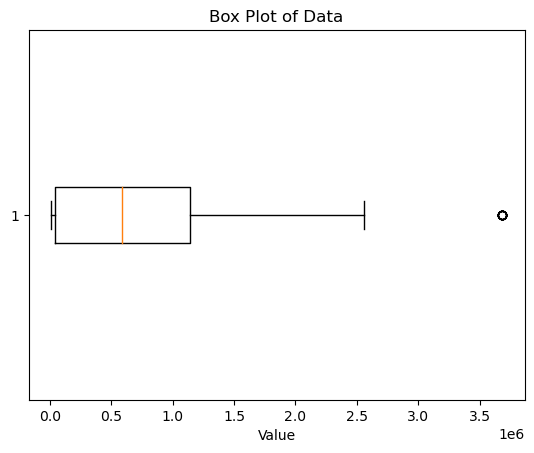

In [61]:
import matplotlib.pyplot as plt

plt.boxplot(norms, vert=False)

# Add titles and labels
plt.title('Box Plot of Data')
plt.xlabel('Value')

# Show the plot
plt.show()

In [63]:
norms.sort()
norms

[10509.4345703125,
 10509.4345703125,
 11779.2177734375,
 11779.2177734375,
 11779.2177734375,
 11779.2177734375,
 11779.2177734375,
 11779.2177734375,
 11779.2177734375,
 11779.2177734375,
 11779.2177734375,
 11779.2177734375,
 11779.2177734375,
 11779.2177734375,
 12028.517578125,
 12028.517578125,
 12028.517578125,
 13139.8212890625,
 13830.6201171875,
 13830.6201171875,
 15364.796875,
 15370.0712890625,
 15370.0712890625,
 16237.2568359375,
 16237.2568359375,
 16237.2568359375,
 16237.2568359375,
 16237.2568359375,
 16237.2568359375,
 16237.2568359375,
 16237.2568359375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 23294.71484375,
 24828.53125,
 24828.53125,
 24828.53125,
 24828.53125,
 38025.72265625,
 41684.5390625,
 41684.5390625,
 41684.5390625,
 41684.5390625,
 41684.5390625,
 41684.5390625,
 41684.5390